In [1]:
from pyspark.sql import SparkSession
spark = SparkSession \
.builder \
.appName("Python Spark SQL basic example") \
.config("spark.some.config.option", "some-value") \
.getOrCreate()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from pyspark.sql.functions import col, countDistinct, trim, length, to_date, year, month, when
from pyspark.sql import functions as F 

In [3]:
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Serif'
our_colors = ["#1f487e","#1d3461", "#376996", "#6290c8", "#829cbc"]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=our_colors)


In [17]:
df_lighter_books = spark.read.json("lighter_books.json")
df_lighter_authors = spark.read.json("lighter_authors.json")

In [18]:
df_lighter_books.createOrReplaceTempView("lighter_books")
df_lighter_authors.createOrReplaceTempView("lighter_authors")

In [19]:
df_lighter_books = df_lighter_books.dropDuplicates()
df_lighter_authors = df_lighter_authors.dropDuplicates()

# [RQ1] Exploratory Data Analysis (EDA) 
We have two main files in which our data are saved, "lighter_authors.json" and "lighter_books.json". 
- To begin the exploratory analysis we start by looking at the first few rows of our datasets. We created the count_columns_type function in order to see how many columns in the dataset contain numeric, categorical, or other type of variables. We also printed out how many rows each dataset has. 
Books_lighter has 26 columns and a total of 7027431 rows while Authors_lighter has 12 columns and 351767 rows. It is also useful to print the list with all the columns of the datasets.

In [7]:
# Function to obtain the type of the columns
def count_columns_type(data):
    categorial = 0
    numeric = 0
    other = 0
    from pyspark.sql.types import StringType, DoubleType, LongType
    for col in data.columns:
        c_type = data.schema[col].dataType
        #print(c_type)
        if isinstance(c_type, StringType):
            categorial += 1
            
        elif isinstance(c_type, LongType) or isinstance(c_type,DoubleType):
            numeric += 1
        else:
            other += 1
    print("The number of categorial columns is: ", categorial)
    print("The number of numeric columns is: ", numeric)
    print("The number of other types of columns is: ", other)

In [8]:
books_5 = spark.sql("SELECT (*) FROM lighter_books LIMIT 5").toPandas()
display(books_5)
print("The total number of columns is:", len(df_lighter_books.columns))
count_columns_type(df_lighter_books)
count_books = spark.sql("SELECT COUNT(*) FROM lighter_books").toPandas()
print("The number of rows in the books file is:" , count_books.iloc[0,0])

,asin,author_id,author_name,authors,average_rating,description,edition_information,format,id,image_url,...,publisher,rating_dist,ratings_count,series_id,series_name,series_position,shelves,text_reviews_count,title,work_id
0,,1077326,J.K. Rowling,"[(1077326, J.K. Rowling, ), (2927, Mary GrandP...",4.50,There is a door at the end of a silent corrido...,US Edition,Paperback,2,https://i.gr-assets.com/images/S/compressed.ph...,...,Scholastic Inc.,5:1674064|4:664833|3:231195|2:41699|1:16215|to...,2628006,45175,Harry Potter,5,"[(324191, to-read), (52675, currently-reading)...",44716,Harry Potter and the Order of the Phoenix (Har...,2809203
1,,1077326,J.K. Rowling,"[(1077326, J.K. Rowling, ), (2927, Mary GrandP...",4.48,Harry Potter's life is miserable. His parents ...,Library Edition,Hardcover,3,https://i.gr-assets.com/images/S/compressed.ph...,...,Scholastic Inc,5:4801606|4:1681521|3:623286|2:145898|1:125040...,7377351,45175,Harry Potter,1,"[(63540, fantasy), (57260, favorites), (20889,...",116930,Harry Potter and the Sorcerer's Stone (Harry P...,4640799
2,,1077326,J.K. Rowling,None,4.43,The Dursleys were so mean and hideous that sum...,,Hardcover,4,https://i.gr-assets.com/images/S/compressed.ph...,...,Scholastic,5:1690166|4:781011|3:313727|2:54687|1:15453|to...,2855044,45175,Harry Potter,2,"[(282341, to-read), (67110, currently-reading)...",55286,Harry Potter and the Chamber of Secrets (Harry...,6231171
3,,1077326,J.K. Rowling,"[(1077326, J.K. Rowling, ), (2927, Mary GrandP...",4.57,"For twelve long years, the dread fortress of A...",,Mass Market Paperback,5,https://i.gr-assets.com/images/S/compressed.ph...,...,Scholastic Inc.,5:1994597|4:696545|3:212678|2:28915|1:13959|to...,2946694,45175,Harry Potter,3,"[(292815, to-read), (52580, fantasy), (49479, ...",58023,Harry Potter and the Prisoner of Azkaban (Harr...,2402163
4,,1077326,J.K. Rowling,"[(1077326, J.K. Rowling, ), (2927, Mary GrandP...",4.56,Harry Potter is midway through his training as...,First Scholastic Trade Paperback Edition,Paperback,6,https://i.gr-assets.com/images/S/compressed.ph...,...,Scholastic,5:1808039|4:663849|3:193604|2:27759|1:12425|to...,2705676,45175,Harry Potter,4,"[(287086, to-read), (60111, currently-reading)...",48637,Harry Potter and the Goblet of Fire (Harry Pot...,3046572


The total number of columns is: 26
The number of categorial columns is:  17
The number of numeric columns is:  7
The number of other types of columns is:  2
The number of rows in the books file is: 7027431


In [9]:
authors_5 = spark.sql("SELECT (*) FROM lighter_authors LIMIT 5").toPandas()
display(authors_5)
print("The total number of columns is:", len(df_lighter_authors.columns))
count_columns_type(df_lighter_authors)
count_authors = spark.sql("SELECT COUNT(*) FROM lighter_authors").toPandas()
print("The number of rows in the authors file is:" , count_authors.iloc[0,0])

,about,average_rating,book_ids,fans_count,gender,id,image_url,name,ratings_count,text_reviews_count,work_ids,works_count
0,"Douglas Noël Adams was an English author, comi...",4.19,"[386162, 13, 8695, 8694, 6091075, 365, 569429,...",19826,male,4,https://images.gr-assets.com/authors/159137433...,Douglas Adams,2862064,62681,"[3078186, 135328, 1877624, 74123, 3078120, 104...",106
1,"William McGuire ""Bill"" Bryson, OBE, FRS was bo...",4.02,"[9791, 21, 28, 24, 7507825, 27, 10538, 25, 26,...",16144,male,7,https://images.gr-assets.com/authors/157859752...,Bill Bryson,1417316,84176,"[613469, 2305997, 940892, 2611786, 7800569, 31...",75
2,"Jude Fisher is the pseudonym for <a href=""http...",4.53,"[349254, 15222, 14833682, 15221, 18126815, 152...",60,female,10,https://images.gr-assets.com/authors/141145711...,Jude Fisher,56159,352,"[17150, 808427, 20487307, 90550, 25460625, 171...",14
3,James Hamilton-Paterson's work has been transl...,3.79,"[40, 9416484, 12482, 3753106, 26889789, 104764...",72,male,12,https://images.gr-assets.com/authors/127051738...,James Hamilton-Paterson,3302,480,"[4417, 14300808, 14780, 3796968, 44703121, 103...",45
4,Mark Andrew Watson (born 13 February 1980) is ...,3.60,"[8466327, 15739968, 22756778, 51026133, 260451...",179,male,14,https://images.gr-assets.com/authors/133175379...,Mark Watson,7979,772,"[13330815, 19109351, 42306244, 72694240, 26291...",61


The total number of columns is: 12
The number of categorial columns is:  4
The number of numeric columns is:  6
The number of other types of columns is:  2
The number of rows in the authors file is: 351767


In [10]:
df_lighter_books.columns

['asin',
 'author_id',
 'author_name',
 'authors',
 'average_rating',
 'description',
 'edition_information',
 'format',
 'id',
 'image_url',
 'isbn',
 'isbn13',
 'language',
 'num_pages',
 'original_publication_date',
 'publication_date',
 'publisher',
 'rating_dist',
 'ratings_count',
 'series_id',
 'series_name',
 'series_position',
 'shelves',
 'text_reviews_count',
 'title',
 'work_id']

In [11]:
df_lighter_authors.columns

['about',
 'average_rating',
 'book_ids',
 'fans_count',
 'gender',
 'id',
 'image_url',
 'name',
 'ratings_count',
 'text_reviews_count',
 'work_ids',
 'works_count']

- For numerical variables, statistics such as count, mean, standard deviation, minimum value, and maximum value can be obtained through the describe() function.
- For categorical variables, frequency tables can be constructed in which the absolute frequency of character modes can be seen. We decided to show them for book format and publisher. The most commonly used formats are Paperback, Hardcover ,ebook, Audio CD and Kindle Edition while the most popular publishers are Book on Demand Ltd , Createspace Independent Publishing Platform, Smashwords Edition Turtleback Books and Books LLC, Wiki Series.
- For the author dataset we decided to make a barplot for the gender of the authors, we changed the y-axis to logarithmic scale because it was not possible to see graphically the presence of even genders other than male and female.

In [20]:
# Descriptive statistics for numeric variables of books
statistics_num_var_book = df_lighter_books.select("average_rating", "edition_information", "ratings_count", "text_reviews_count").describe().toPandas()
statistics_num_var_book #6 minutes to run

,summary,average_rating,edition_information,ratings_count,text_reviews_count
0,count,7027431,7027431,7027431,7027431
1,mean,3.306187915612372,4.2425113324187964E11,19458.609666035853,641.7257807298286
2,stddev,1.4357340879502614,1.802437181368138E13,160900.7621571502,4169.806199983708
3,min,0.0,,0,0
4,max,5.0,１,7400639,174524


In [21]:
# Descriptive statistics for numeric variables of authors
statistics_num_var_authors = df_lighter_authors.select("average_rating", "fans_count", "ratings_count", "works_count").describe().toPandas()
statistics_num_var_authors #10 sec to run

,summary,average_rating,fans_count,ratings_count,works_count
0,count,351767,351767,351767,351767
1,mean,3.6511943132812488,111.61573143586521,4770.586308550831,25.937137366495435
2,stddev,1.2114816423862007,2661.0181388659653,97693.95378788895,3066.0828516236847
3,min,-31.0,-33,-41,0
4,max,5.0,766035,27003752,1775176


In [22]:
df_lighter_books = df_lighter_books.filter(trim(col("format")) != "")
df_lighter_books = df_lighter_books.filter(trim(col("publisher")) != "")
df_lighter_books = df_lighter_books.dropna(subset=["format","publisher"])
df_lighter_books.createOrReplaceTempView("lighter_books")

In [23]:
# For categorical variables we can make frequency tables for example abot the format of the books
formats = spark.sql("SELECT format, COUNT(*) FROM lighter_books GROUP BY format ORDER BY COUNT(*) DESC").toPandas()
# The same can be done for the publisher
publishers = spark.sql("SELECT publisher, COUNT(*) FROM lighter_books GROUP BY publisher ORDER BY COUNT(*) DESC").toPandas()
#10 minutes to run

In [24]:
formats.head(5)

,format,count(1)
0,Paperback,2177540
1,Hardcover,952597
2,ebook,868525
3,Audio CD,117705
4,Kindle Edition,109497


In [27]:
publishers.head(5)

,publisher,count(1)
0,Book on Demand Ltd.,108860
1,Createspace Independent Publishing Platform,89302
2,Smashwords Edition,79087
3,Turtleback Books,58453
4,"Books LLC, Wiki Series",56899


In [28]:
# About the authors we can do a plot to see the distribution of the gender
df_lighter_authors = df_lighter_authors.filter(trim(col("gender")) != "")
df_lighter_authors = df_lighter_authors.dropna(subset=["gender"])
df_lighter_authors = df_lighter_authors.withColumn("gender_standard", when(col("gender").isin("non-binary", "Nonbinary", "Non-binary", "nonbinary"), "Non-binary").otherwise(col("gender")))
df_lighter_authors.createOrReplaceTempView("lighter_authors") #needed again because the standardized gender
gender_authors = spark.sql("SELECT gender_standard, COUNT(*) FROM lighter_authors GROUP BY gender_standard ORDER BY count(*) DESC").toPandas()
gender_authors.head(5)

,gender_standard,count(1)
0,male,138179
1,female,109878
2,Non-binary,95
3,genderqueer,28
4,Agender,11


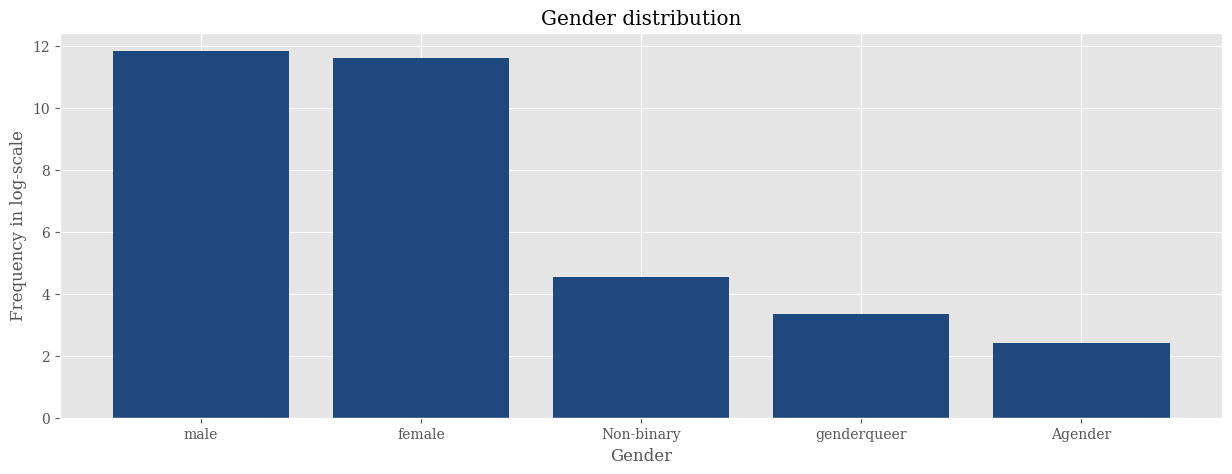

In [30]:
plt.figure(figsize=(15,5))
plt.bar(gender_authors["gender_standard"].head(5),np.log(gender_authors["count(1)"].head(5))) #logaritmic scale to make the differences visible
plt.title('Gender distribution')  
plt.xlabel('Gender')              
plt.ylabel('Frequency in log-scale')  
plt.show()

# [RQ2] Let’s finally dig into this vast dataset, retrieving some vital information:
- Plot the number of books for each author in descending order.

In [31]:
# Cleaning a bit the data
df_lighter_books = df_lighter_books.filter(trim(col("author_name")) != "") # removes rows with empty author_name
df_lighter_books = df_lighter_books.dropna(subset=["author_name"])
# Query to count how many times an author appears
freq_authors = df_lighter_books.groupBy("author_name").count().orderBy("count", ascending=False).toPandas() #5  minutes to run
# We see that some of them are not properly authors like "Anonymous","Unknown","NOT A BOOK" and so we eliminate them
freq_authors = freq_authors.drop([1,2,4,5,7])

In [33]:
freq_authors

,author_name,count
0,Jesse Russell,90083
3,Philip M. Parker,27415
6,Books LLC,18170
8,William Shakespeare,13680
9,Agatha Christie,9834
...,...,...
237093,Γιώργος Παυλίδης,1
237094,Rachel Wells,1
237095,Yanka Bryl,1
237096,Diana Lawrence,1


There are 237093 rows in the dataset with the author's name and the number of books written, representing them all together would make the graph unreadable, so we thought of two strategies. The idea is to recreate a stratified sampling, for us each stratum of the population consists of the number of books written and from each stratum we take only one author who precisely represents his stratum. In this way we get 1303 authors. To represent them all we created the function division_data that devides the dataset into n parts and then we made a barplot for each of the n divisions of the data. However, the result we get is not very clear, there are some authors who have so much more than others and then the number of books written goes down to 1.
Our second attempt to make sure that we could get a readable graph but without also excluding those who wrote the data was to make a sample from the stratified sampling already done 

### First attempt: sampling only one author for each value of book count

In [34]:
freq_authors["count"].value_counts() #There are way to many authors to be seen in a plot, a possible strategy to show the distribution of the books is to
# sample one author for each value, we will have 1303 bars, maybe we should do 10 plots 
freq_authors_sample = freq_authors.groupby("count").apply(lambda group: group.sample(1)).reset_index(drop=True).sort_values(by="count", ascending=False)
freq_authors_sample

,author_name,count
1037,Jesse Russell,90083
1036,Philip M. Parker,27415
1035,Books LLC,18170
1034,William Shakespeare,13680
1033,Agatha Christie,9834
...,...,...
4,John B. Ford,5
3,Marilyn Harris,4
2,Per Engdahl,3
1,Iain S. Thomas,2


In [35]:
def division_data(data,n):
    interval_len = len(data) // n
    divisions = []
    start = 0
    for i in range(n):
        end = start + interval_len
        divisions.append(data.iloc[start:end])
        start = end
    # if there are any rows left, concat them with the last chunk
    if start < len(data):
        divisions[-1] = pd.concat([divisions[-1], data.iloc[start:]])
    return divisions

C:\Users\susan\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:89: UserWarning: Glyph 1571 (\N{ARABIC LETTER ALEF WITH HAMZA ABOVE}) missing from current font.
  func(*args, **kwargs)
C:\Users\susan\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:89: UserWarning: Matplotlib currently does not support Arabic natively.
  func(*args, **kwargs)
C:\Users\susan\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:89: UserWarning: Glyph 1606 (\N{ARABIC LETTER NOON}) missing from current font.
  func(*args, **kwargs)
C:\Users\susan\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:89: UserWarning: Glyph 1610 (\N{ARABIC LETTER YEH}) missing from current font.
  func(*args, **kwargs)
C:\Users\susan\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:89: UserWarning: Glyph 1587 (\N{ARABIC LETTER SEEN}) missing from current font.
  func(*args, **kwargs)
C:\Users\susan\AppData\Roaming\Python\Python311

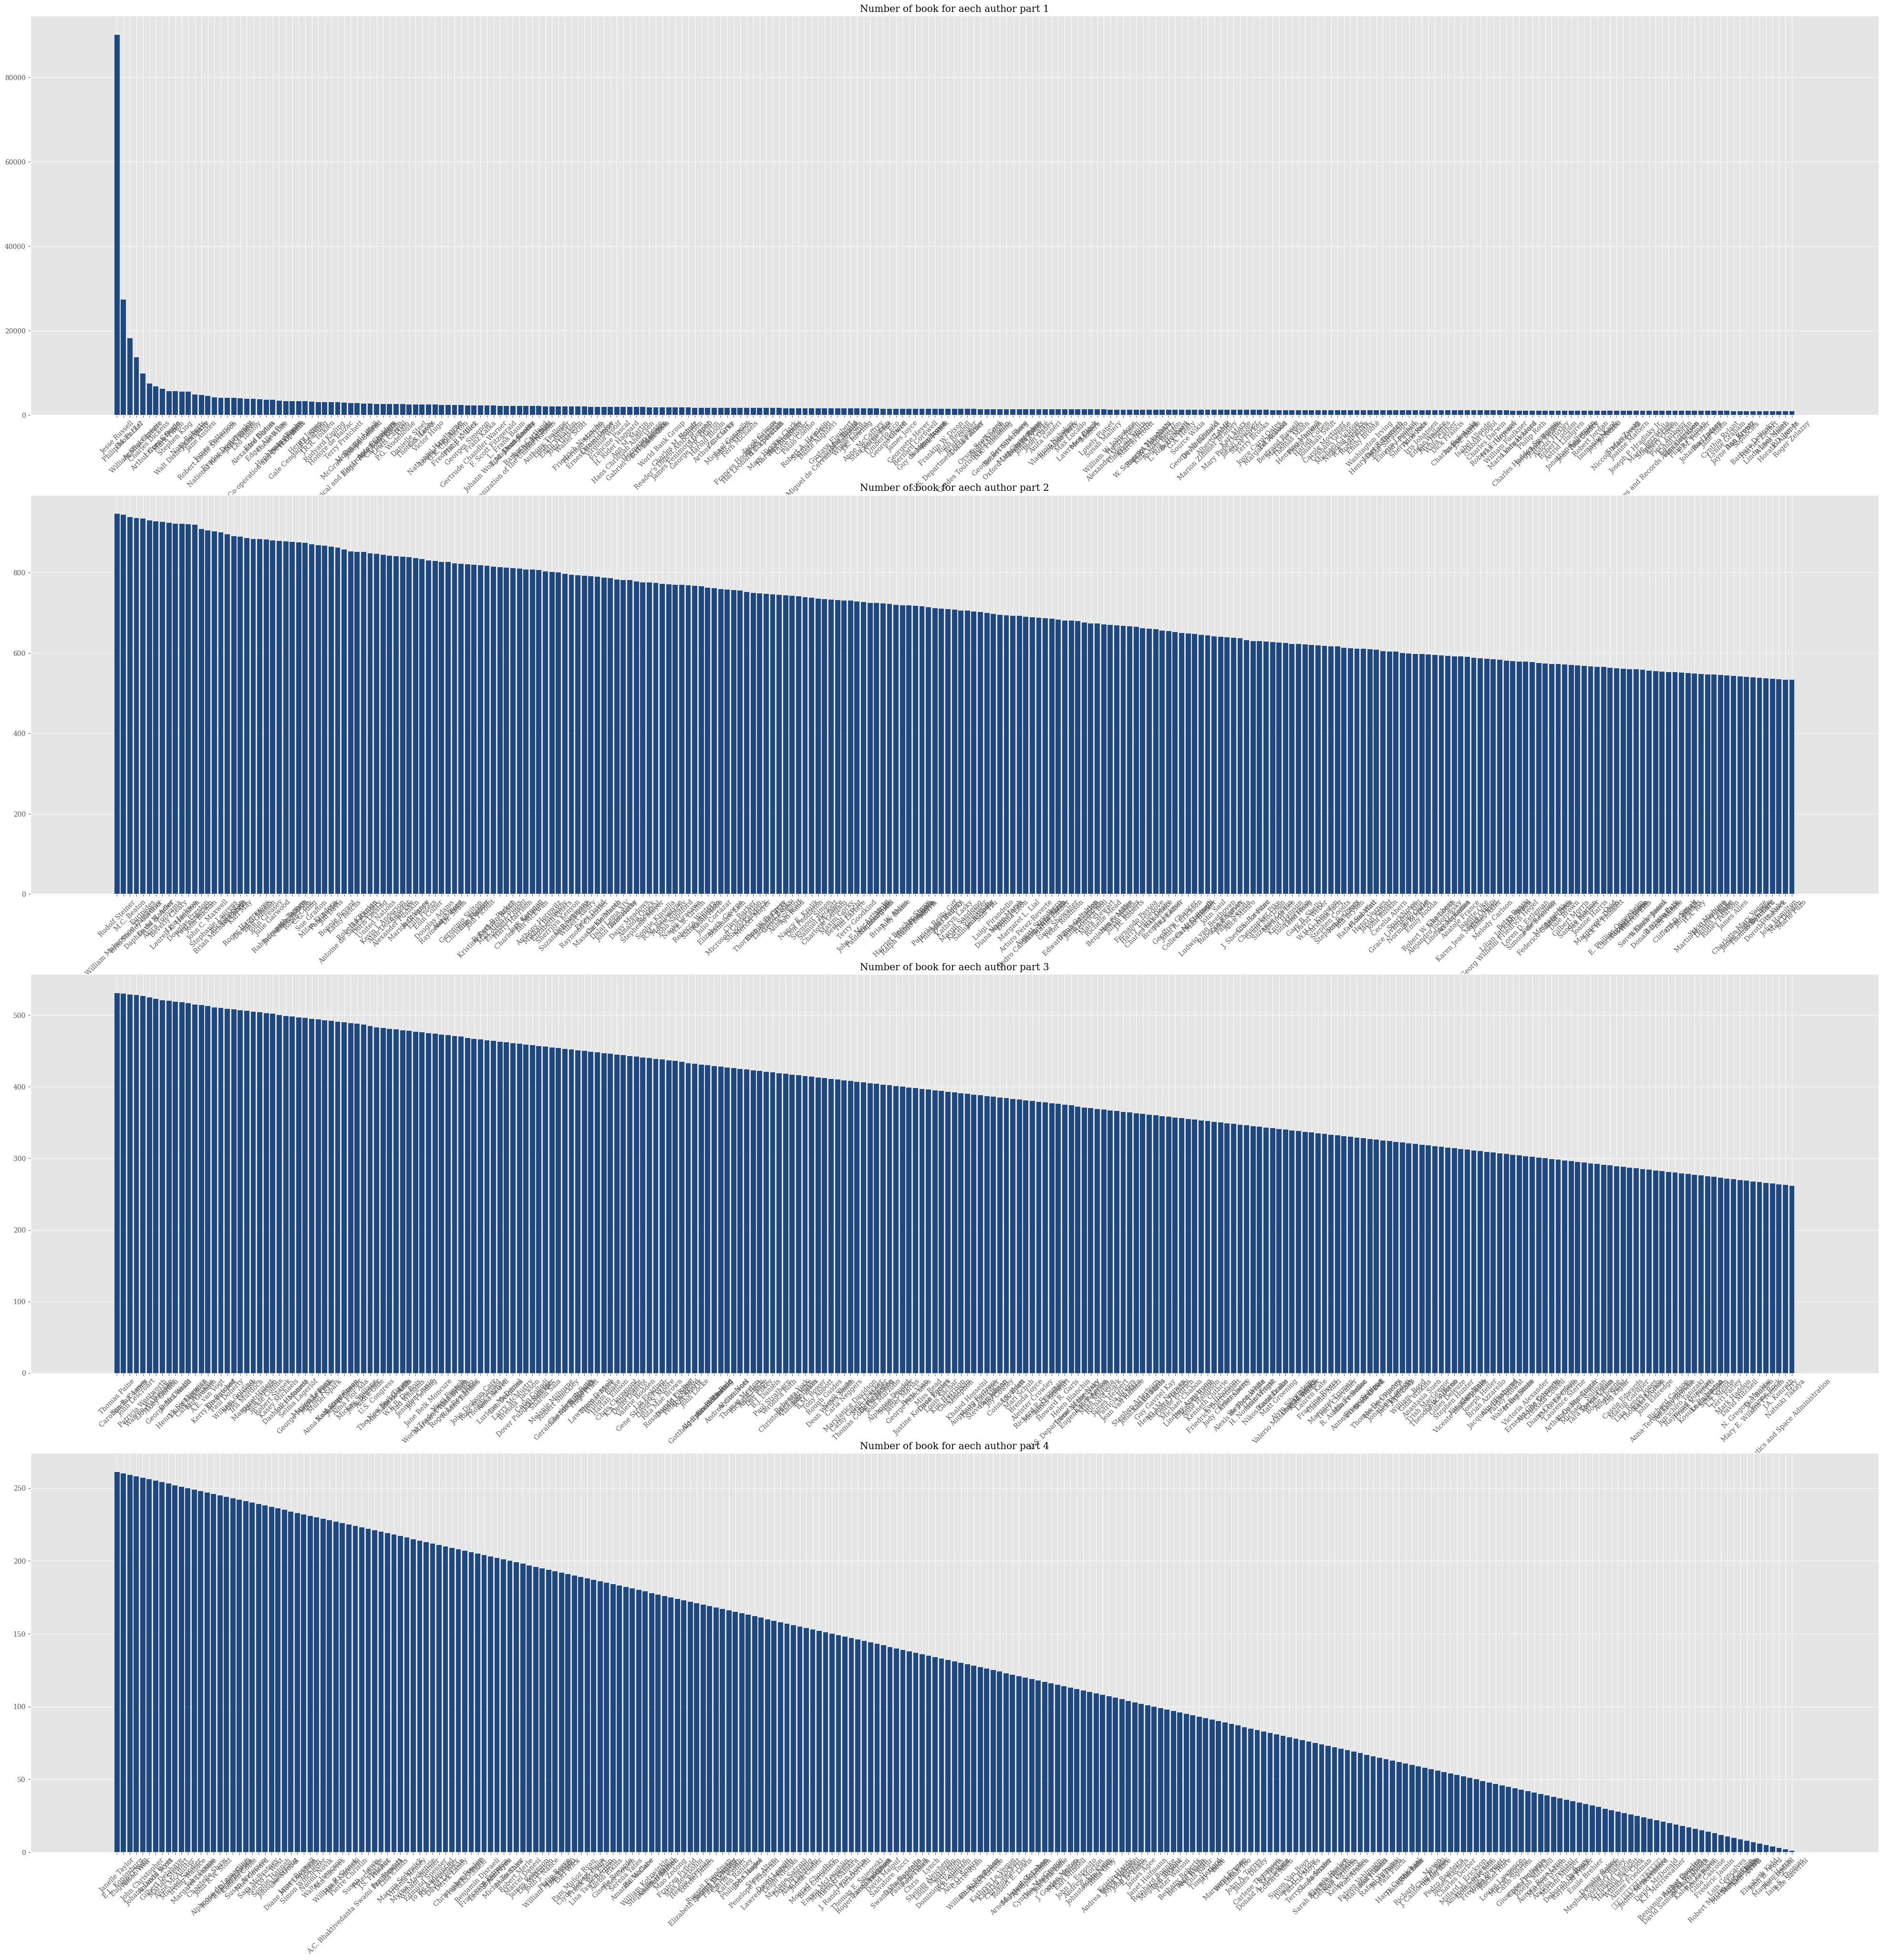

In [54]:
divised = division_data(freq_authors_sample,4)
fig, axes = plt.subplots(len(divised), 1, figsize=(50, 50)) # we avoid sharey = True  bacause all the other graphs would be not visible 
for i,data in enumerate(divised):
    ax = axes[i]
    ax.bar(data["author_name"],data["count"])
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_title(f"Number of book for aech author part {i + 1}")

### Second attempt: draw a sample of n = 30 and plot the results

In [58]:
freq_authors_sample_2 = freq_authors_sample.sample(30).sort_values(by="count", ascending=False)

C:\Users\susan\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 1593 (\N{ARABIC LETTER AIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\susan\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Matplotlib currently does not support Arabic natively.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\susan\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 1576 (\N{ARABIC LETTER BEH}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\susan\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 1583 (\N{ARABIC LETTER DAL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\susan\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 1575 (\N{ARABIC LETTER ALEF}) missing from current

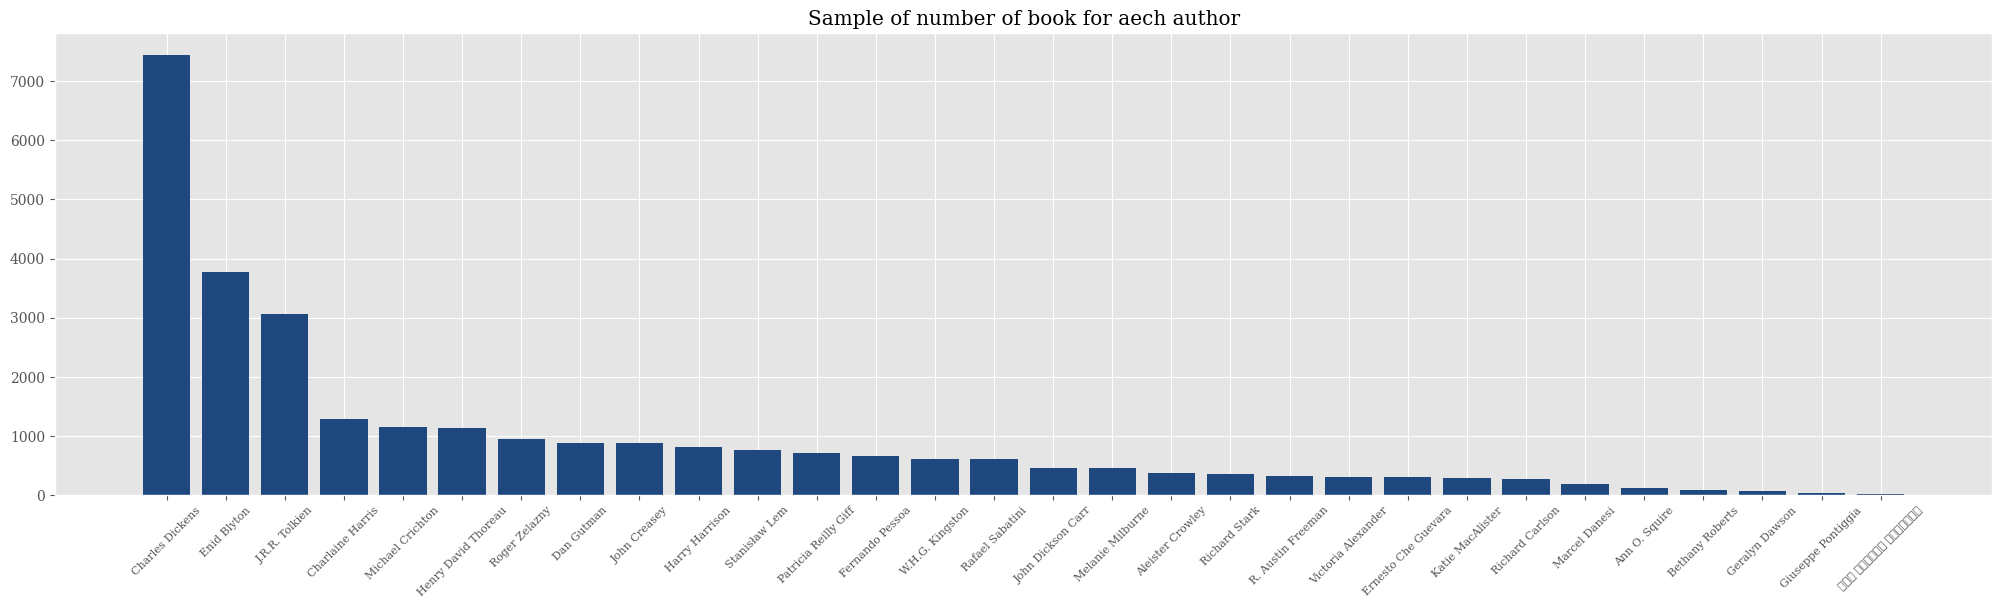

In [59]:
plt.figure(figsize=(25,6))
plt.xticks(rotation = 45, fontsize = 8)
plt.bar(freq_authors_sample_2["author_name"], freq_authors_sample_2["count"])
plt.title("Sample of number of book for aech author")
plt.show()

- Which book has the highest number of reviews?

In [60]:
max_rating_count = spark.sql("SELECT MAX(ratings_count) FROM lighter_books").toPandas()
max_rating_count = max_rating_count["max(ratings_count)"][0]
book_highest_review = spark.sql(f"SELECT title FROM lighter_books WHERE ratings_count == {max_rating_count}").toPandas() 
#put the f to incorporate max_rating_count inside the query
book_highest_review["title"][0]

'Harry Potter und der Stein der Weisen (Harry Potter,#1)'

- Which are the top ten and ten worst books concerning the average score?

In [61]:
df_lighter_books = df_lighter_books.filter(trim(col("average_rating")) != "") # removes rows with empty average rating
df_lighter_books = df_lighter_books.dropna(subset=["average_rating"])

In [62]:
average_score_10_worse = spark.sql("SELECT title, average_rating FROM lighter_books ORDER BY average_rating LIMIT 10").toPandas() #5 minutes to run
average_score_10_worse

,title,average_rating
0,Sean's Tape-Audio,0.0
1,Bible in Spoken Word Cassette Narrated by Char...,0.0
2,Death of Aunt,0.0
3,Classic Fairy Stories: Traditional Tales: Trad...,0.0
4,"Faith, Hope, and Luck, Session 5: Discover Wha...",0.0
5,Hindi New Testament,0.0
6,The Life And Times Of A Stickleback,0.0
7,"Costa Rica, pura vida. Volumen II",0.0
8,Marathon: Going the Distance,0.0
9,American Headway 1,0.0


In [63]:
average_score_10_best = spark.sql("SELECT title, average_rating FROM lighter_books ORDER BY average_rating DESC LIMIT 10").toPandas()
average_score_10_best

,title,average_rating
0,The Chakras-Keys to Self-Understanding & Freedom,5.0
1,Wind,5.0
2,The Revolutionary Art of the Future: Rediscove...,5.0
3,Out of My Hands,5.0
4,Christmas,5.0
5,Perfect Italian (Learn Italian with the Michel...,5.0
6,The Long Dive,5.0
7,Los Many Mundos of Raulrsalinas: Un Poetic Jaz...,5.0
8,Nirvana Drum Collection,5.0
9,Precious Moments: Autumn Adventures,5.0


In [64]:
df_lighter_books = df_lighter_books.filter(trim(col("language")) != "") # removes rows with empty language
df_lighter_books = df_lighter_books.dropna(subset=["language"])

- Explore the different languages in the book’s dataset, providing a proper chart summarizing how these languages are distributed throughout our virtual library.

In [65]:
df_languages = df_lighter_books.groupBy("language").count().toPandas()

In [66]:
df_languages = df_languages.sort_values(by="count", ascending=False)
df_languages
# There are 301 different languages!

,language,count
49,eng,884148
91,ita,98654
104,ger,91486
96,spa,90072
0,fre,76737
...,...,...
8,tuk,1
166,bat,1
224,men,1
222,tut,1


English is the predominant language in the dataset, we decided to use a pie chart to represent it because visually it is the one that makes it clear which language is the most widely used.  
We did not put all the languages in the chart because some occupy too small slices of the chart, we stopped at the top 30 most widely used languages.

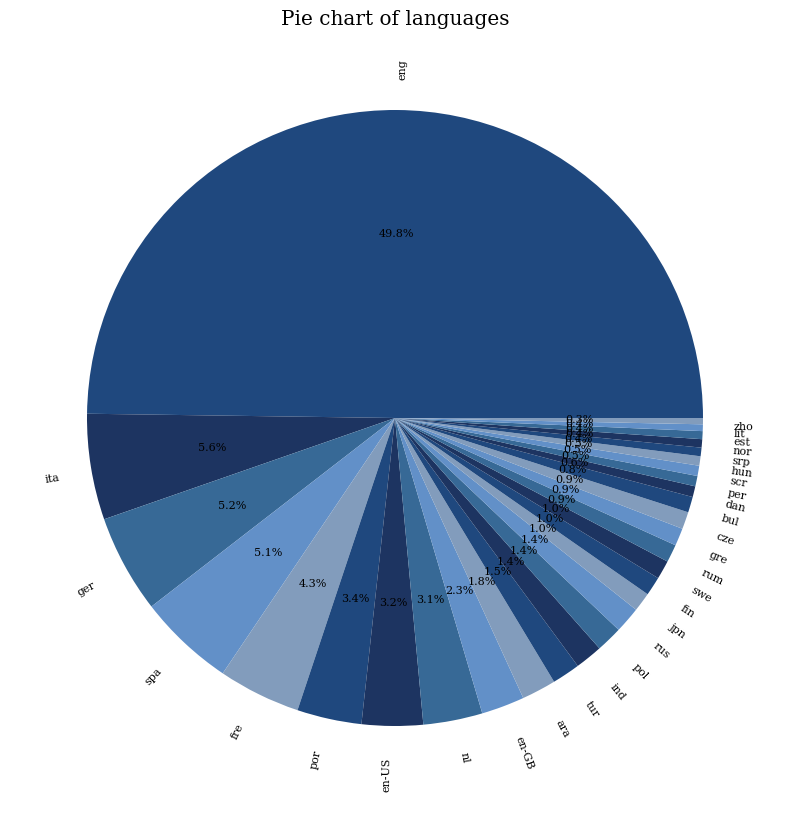

In [70]:
plt.figure(figsize=(10,10))
plt.pie(df_languages["count"].head(30), labels= df_languages["language"].head(30), autopct='%1.1f%%', rotatelabels= True,  textprops={'size': 8} )
plt.title("Pie chart of languages")
plt.show()

- How many books have more than 250 pages?

In [71]:
books_more_250 = spark.sql(" SELECT COUNT(*) FROM lighter_books WHERE num_pages > 250").toPandas()

In [72]:
print("There are", books_more_250["count(1)"][0], " with more taht 250 pages")

There are 1668596  with more taht 250 pages


- Plot the distribution of the fans count for the 50 most prolific authors (the ones who have written more books).

In [73]:
prolific_50_fans = spark.sql("""
    SELECT name, fans_count
    FROM lighter_authors 
    WHERE name IN (SELECT author_name
                   FROM lighter_books
                   GROUP BY author_name
                   ORDER BY COUNT(*) DESC)
    ORDER BY fans_count DESC
    LIMIT 50
""")

In [74]:
prolific_50_fans_df = prolific_50_fans.toPandas()

In [93]:
prolific_50_fans_df.head(5)

,name,fans_count
0,Stephen King,766035
1,Veronica Roth,455358
2,Colleen Hoover,356633
3,Rick Riordan,339346
4,James Patterson,317040


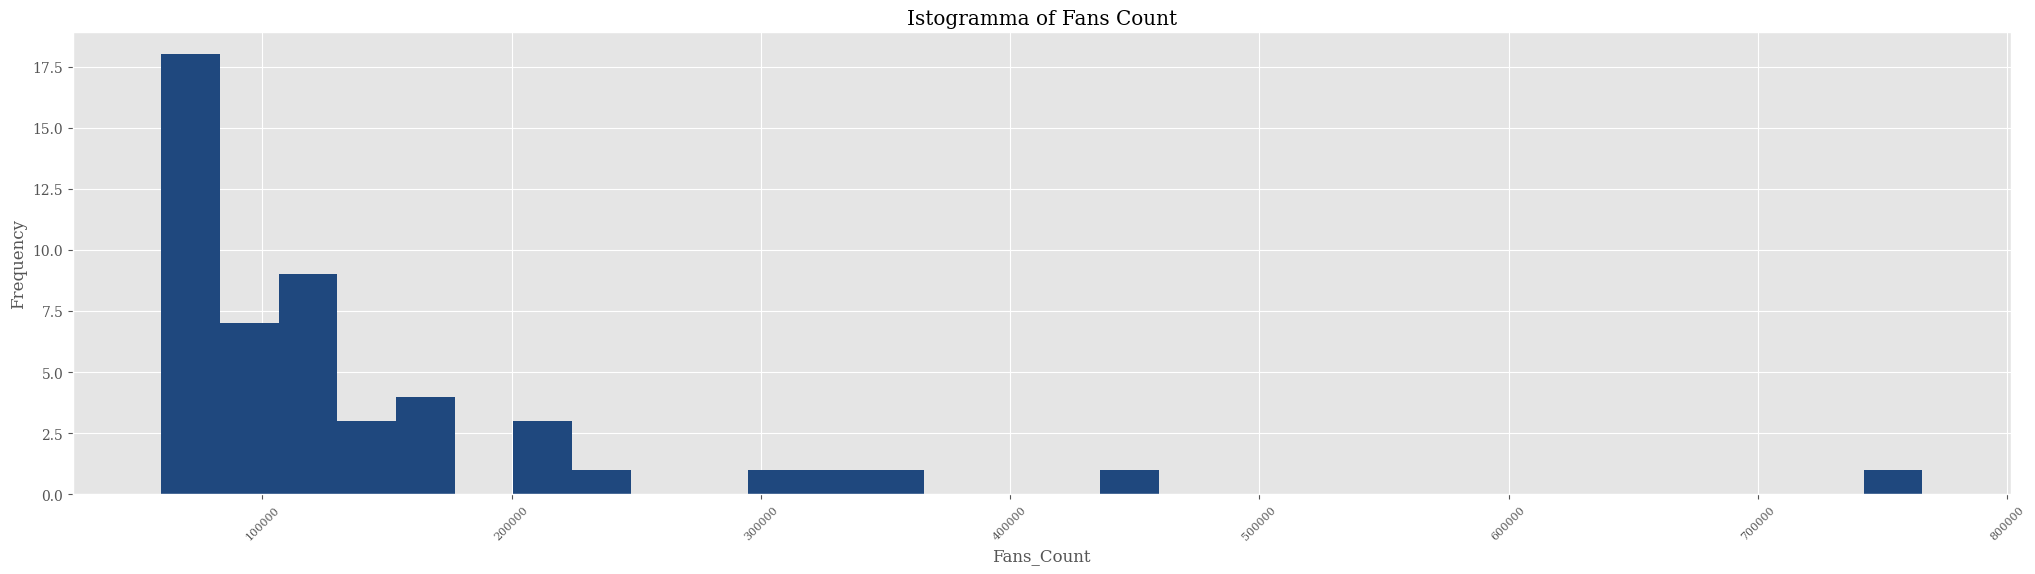

In [91]:
# Usually a histogram is the right method to represent the distribution of a variable but in this case the fans_count cannot be considered 
# a continuous variable and in fact the histogram has "holes" in it. 
plt.figure(figsize=(25, 6))
plt.xticks(rotation=45, fontsize=8)
plt.hist(prolific_50_fans_df["fans_count"], bins=30)  
plt.xlabel("Fans_Count") 
plt.ylabel("Frequency")  
plt.title("Istogramma of Fans Count")  
plt.show()

Text(0.5, 1.0, 'Barplot of Fans Count')

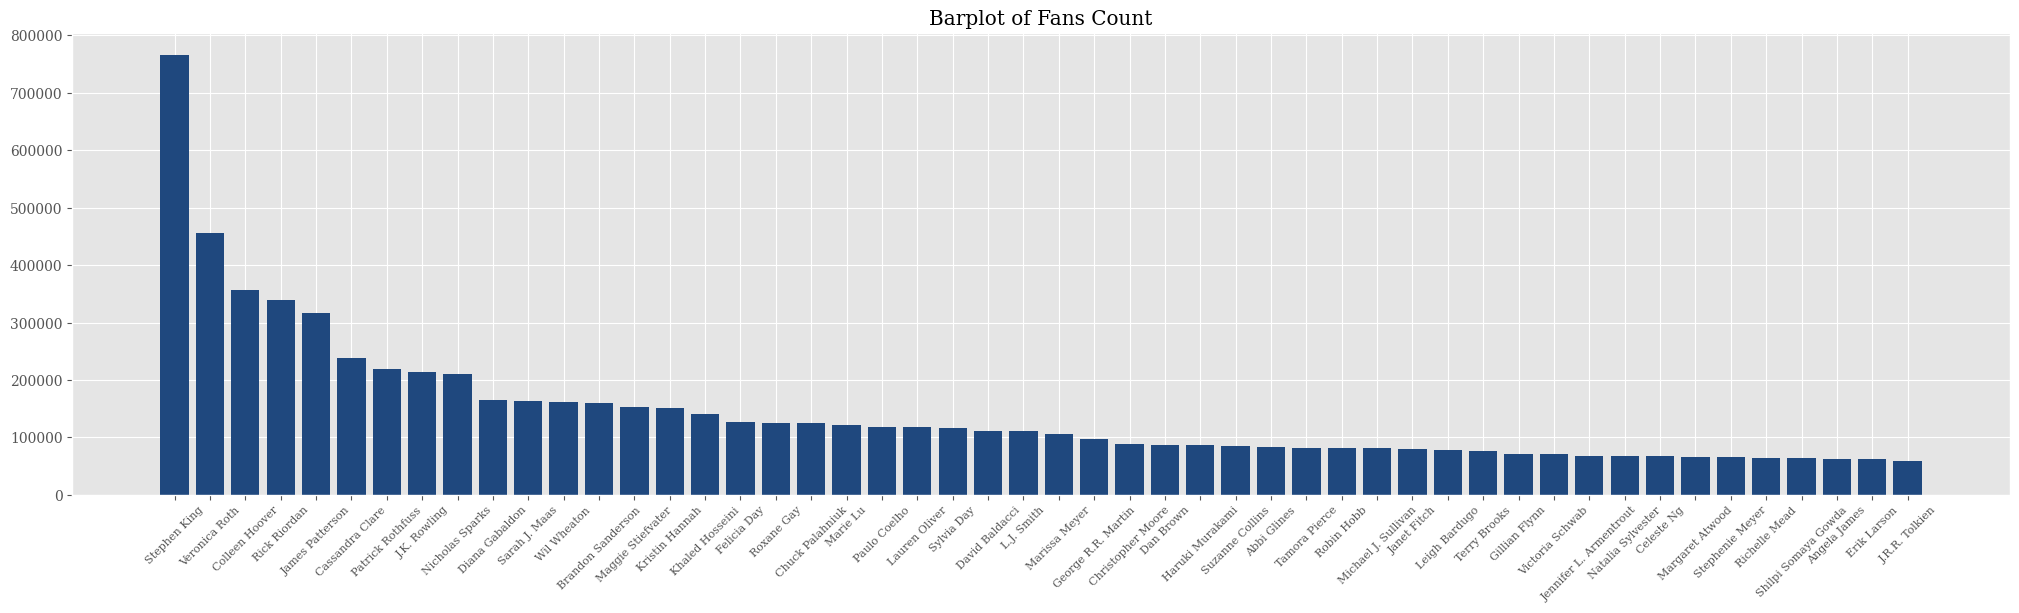

In [92]:
#Therefore, to have a graph that better represents the distribution of fans for the 50 most prolific authors, one can use a barplot
plt.figure(figsize=(25,6))
plt.xticks(rotation = 45, fontsize = 8)
plt.bar(prolific_50_fans_df["name"], prolific_50_fans_df["fans_count"])
plt.title("Barplot of Fans Count")

# [RQ8] Charts, statistical tests, and analysis methods are splendid tools to illustrate your data-driven decisions to check whether a hypothesis is correct.

- Can you demonstrate that readers usually rate the longest books as the worst?
- Compare the average rate distribution for English and non-English books with a proper statistical procedure. What can you conclude about those two groups?
- About the two groups in the previous question, extract helpful statistics like mode, mean, median, and quartiles, explaining their role in a box plot.
- It seems reasonable to assume that authors with more fans should have more reviews, but maybe their fans are a bit lazy. Confirm or reject this with a convenient statistical   test or a predictive model.
- Provide a short survey about helpful statistical tests in data analysis and mining: focus on hypothesis design and the difference between parametric and nonparametric tests, explaining the reasons behind the choice of one of these two tests.